# Entrenamiento O3


Una vez que se tienen los datos limpios y procesados, estos pueden ser usados para la generación de los modelos. A continuación se muestra el flujo trabajo para la generación de los modelos:

<img src="./gen_modelos.png" style="height:300px">

Los modelos utilizados son del tipo __supervisado___, esto quiere decir que se necesita tener el valor real para poder generar los modelos, este valor corresponde a la columna del contaminante a pronosticar a una hora específica.  

Una vez que se tiene esta columna identificado, es necesario dividir los datos de entrenamiento en dos conjuntos: de __entrenamiento__ y __prueba__. La razón de dividirlos es para poder cuantiﬁcar el desempeño y el correcto funcionamiento de los modelos. El conjunto de entrenamiento correspondió al __80%__ de los datos totales y en éste se ejecutarán los modelos estadísticos para obtener los árboles de decisión y con el conjunto de prueba que correspondió al __20%__ restante, se comparará el pronóstico de los modelos con el valor real.

Con el conjunto de entrenamiento se ejecutaron todas las pruebas realizadas, aplicando los modelos de machine learning ya mencionados. Los modelos se optimizaron para tener un correcto pronóstico de valores alrededor del nivel de contaminación de la contingencia ambiental. Los modelos de los tres contaminantes son capaces de generar el pronóstico hasta de 24 horas, para cada hora se generó un modelo de manera que se generaron 24 modelos.


### Métricas de Valoración
Para medir el desempeño de un modelo de pronóstico es importante contar con una métrica de desempeño. Medir el desempeño del pronóstico es importante para saber que los métodos y características con los que trabaja el pronóstico son los adecuados. Además, calcular el desempeño de los modelos nos ayudará en la búsqueda de partes del pronóstico que no trabajen de manera óptima y con esto tomar decisiones para mejorar el desempeño del mismo. Las principales métricas usadas para medir el desempeño del modelo son el RMSE que nos indica qué tanto se aleja la predicción del valor real, la R2 que determina la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo y la precisión que nos indica cuántos falsos positivos genera el modelo es decir, cuántas contingencias son pronosticadas incorrectamente por cada contingencia pronosticada correctamente.


__Pasos y descripción general del notebook__


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [73]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [74]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

## Hacemos una función para graficar

In [75]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

In [76]:
def ploter_title(y_test_0,X_test_0,pronosticados_0,model,titulo,ejex,ejey,color_user,ruta="./savedpicO3.png",dpi_user=300):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color=color_user)
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.title(titulo)
    plt.savefig(ruta, dpi=dpi_user)
    plt.show()

## Cargamos los modelos ya entrenados:

In [77]:
conta = 'O3'

In [78]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [79]:
data_hour_merge = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline-norberto/datos/datos_modelos_O3.csv")

In [80]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')

data_hour_merge["hora"] = [row["fecha"].hour for index, row in data_hour_merge.iterrows()]

data_hour_merge["hora"].dtypes

list_hours = [15,16,17]

data_hour_merge= data_hour_merge[data_hour_merge["hora"].isin(list_hours)]

In [81]:
data_hour_merge[["fecha","O3_1.0_max","O3_max_frcst_1"]].tail(10)

,fecha,O3_1.0_max,O3_max_frcst_1
33555,2015-01-07 15:00:00,44.0,59.0
33577,2015-01-06 17:00:00,47.0,39.0
33578,2015-01-06 16:00:00,46.0,44.0
33579,2015-01-06 15:00:00,44.0,47.0
33601,2015-01-05 17:00:00,34.0,29.0
33602,2015-01-05 16:00:00,36.0,32.0
33603,2015-01-05 15:00:00,34.0,34.0
33625,2015-01-04 17:00:00,66.0,36.0
33626,2015-01-04 16:00:00,62.0,68.0
33627,2015-01-04 15:00:00,57.0,66.0


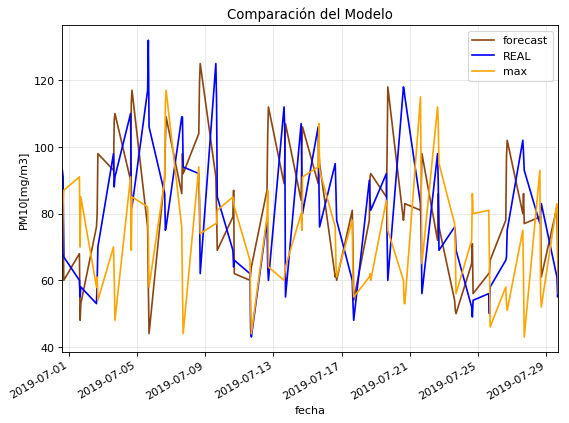

In [82]:
data_hour_merge['fecha'] =  pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M')
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])

data_hour_merge.head(90).plot(x="fecha", y=["O3_max_frcst_22"],ax=ax,label=["forecast"],color="saddlebrown")
data_hour_merge.head(90).plot(x="fecha", y=["O3_max"],ax=ax,label=["REAL"],color="blue")
data_hour_merge.head(90).plot(x="fecha", y=['O3_22.0_max'],ax=ax,label=["max"],color="orange")

#data_hour_merge.head(60).plot(x="fecha", y=["O3_pron_a_12hrs"],ax=ax,label=["Pronóstico PM10 a 12 horas"],color='maroon',dashes=[6, 2])

plt.ylabel("PM10[mg/m3]")
plt.title("Comparación del Modelo")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)

plt.legend()
plt.show()

In [83]:
data_hour_merge.reset_index(inplace=True,drop=True)

In [84]:
data_hour_merge.drop(["fecha","hora"],axis=1,inplace=True)

Definimos la lista de los targets:

In [85]:
target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [86]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [87]:
conta = 'O3'

In [88]:
data_hour_merge.shape

(4300, 130)

# Empezamos con el entrenamiento:

#### HORA 1 

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [104]:
hora = 24

dataset = data_hour_merge.copy()

#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)
X=X[['O3_1.0_max', 'O3_2.0_max', 'RH_25.0_mean', 'TMP_mean_frcst_24',
       'RH_0.0_mean', 'O3_1.0_mean', 'TMP_mean', 'O3_44.0_mean', 'TMP_0.0_max',
       'O3_0.0_max', 'O3_45.0_max', 'TMP_23.0_mean', 'RH_mean_frcst_22',
       'TMP_mean_frcst_23', 'O3_24.0_mean', 'O3_0.0_mean', 'O3_46.0_max',
       'RH_mean_frcst_21', 'TMP_mean_frcst_2', 'RH_2.0_min', 'TMP_46.0_mean',
       'TMP_45.0_mean', 'TMP_mean_frcst_3', 'TMP_mean_frcst_1', 'O3_min',
       'O3_47.0_mean', 'TMP_2.0_mean', 'TMP_23.0_max', 'O3_2.0_mean',
       'O3_21.0_max', 'RH_23.0_mean', 'RH_24.0_mean', 'O3_46.0_mean',
       'RH_45.0_mean', 'TMP_47.0_mean', 'RH_mean_frcst_24', 'RH_mean_frcst_3',
       'RH_44.0_mean', 'O3_24.0_max', 'RH_2.0_mean', 'RH_mean_frcst_23',
       'RH_1.0_max', 'TMP_1.0_min', 'RH_1.0_mean', 'TMP_1.0_mean',
       'RH_23.0_max', 'RH_46.0_mean', 'TMP_mean_frcst_22', 'O3_45.0_mean',
       'WSP_mean']]
#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [90]:
X_train.shape

(3010, 50)

## Modelo

## Modelos

In [91]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [92]:

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [93]:
training_examples=X_train
training_targets=y_train
validation_examples=X_test
validation_targets=y_test
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,O3_1.0_max,O3_2.0_max,RH_25.0_mean,TMP_mean_frcst_24,RH_0.0_mean,O3_1.0_mean,TMP_mean,O3_44.0_mean,TMP_0.0_max,O3_0.0_max,...,RH_mean_frcst_23,RH_1.0_max,TMP_1.0_min,RH_1.0_mean,TMP_1.0_mean,RH_23.0_max,RH_46.0_mean,TMP_mean_frcst_22,O3_45.0_mean,WSP_mean
count,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,...,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0,3010.0
mean,94.3,90.3,37.3,21.6,34.6,68.1,22.1,41.0,25.2,91.7,...,35.3,52.5,16.3,34.0,22.1,60.9,40.1,21.6,47.7,2.9
std,28.2,26.9,15.3,3.2,15.6,20.5,3.0,19.6,3.2,29.3,...,15.3,20.2,3.5,14.4,2.9,21.1,16.5,3.0,19.8,0.9
min,21.0,23.0,5.1,7.8,4.8,4.2,8.4,3.8,9.8,21.0,...,4.7,8.0,2.9,4.7,7.6,10.0,6.3,7.6,4.1,1.1
25%,75.0,72.0,25.3,19.6,22.7,54.5,20.1,26.0,23.0,71.0,...,23.5,36.0,14.1,23.2,20.2,44.0,27.1,19.8,32.6,2.3
50%,94.0,90.0,35.8,21.9,32.2,69.3,22.3,38.1,25.4,92.0,...,33.3,51.0,16.6,32.4,22.2,62.0,38.3,21.8,46.2,2.8
75%,113.0,108.0,47.6,23.9,44.4,82.2,24.2,53.9,27.5,112.0,...,44.9,68.0,18.8,43.0,24.2,79.0,51.7,23.7,61.2,3.5
max,198.0,196.0,86.9,30.7,87.2,138.3,30.9,119.0,33.6,210.0,...,89.1,100.0,27.5,87.6,30.9,100.0,87.7,30.7,126.8,7.5


Validation examples summary:


,O3_1.0_max,O3_2.0_max,RH_25.0_mean,TMP_mean_frcst_24,RH_0.0_mean,O3_1.0_mean,TMP_mean,O3_44.0_mean,TMP_0.0_max,O3_0.0_max,...,RH_mean_frcst_23,RH_1.0_max,TMP_1.0_min,RH_1.0_mean,TMP_1.0_mean,RH_23.0_max,RH_46.0_mean,TMP_mean_frcst_22,O3_45.0_mean,WSP_mean
count,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,...,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0,1290.0
mean,94.5,90.2,37.6,21.7,34.7,68.4,22.1,40.2,25.2,92.1,...,35.5,53.1,16.4,34.1,22.1,61.4,40.4,21.6,46.9,2.9
std,27.7,26.3,15.6,3.4,15.8,20.6,3.1,19.8,3.4,29.3,...,16.0,20.5,3.6,14.7,3.1,21.1,16.4,3.1,20.3,0.9
min,22.0,23.0,5.5,7.8,5.6,5.0,7.0,3.5,8.0,22.0,...,5.4,10.0,2.7,5.4,6.5,11.0,6.8,8.4,4.9,1.1
25%,76.0,72.0,25.2,19.6,22.2,54.7,20.2,24.8,23.2,70.2,...,23.3,37.0,14.1,22.4,20.3,44.0,27.6,19.8,31.6,2.2
50%,95.0,90.0,36.0,21.9,32.3,69.7,22.2,37.7,25.3,92.0,...,33.1,51.0,16.6,32.1,22.3,63.0,38.4,21.7,45.5,2.7
75%,113.0,108.0,48.5,24.0,45.3,82.6,24.3,52.6,27.5,112.0,...,45.2,70.0,18.8,44.0,24.2,79.0,51.8,23.7,60.1,3.4
max,196.0,183.0,82.3,30.9,89.6,132.2,30.9,126.8,34.1,198.0,...,87.2,100.0,27.5,89.4,30.7,100.0,87.5,30.9,125.8,7.0


Training targets summary:


count   3010.0
mean      86.7
std       31.3
min       11.0
25%       63.0
50%       87.0
75%      108.8
max      210.0
Name: O3_max_frcst_24, dtype: float64

Validation targets summary:


count   1290.0
mean      86.3
std       30.1
min       11.0
25%       65.0
50%       86.5
75%      108.0
max      198.0
Name: O3_max_frcst_24, dtype: float64

## Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [94]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [95]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [96]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 40
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

  

    #   dnn_regressor = tf.estimator.DNNRegressor(
    #       feature_columns=construct_feature_columns(training_examples),
    #       hidden_units=hidden_units,
    #       optimizer=my_optimizer,
    #   )

In [97]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 100
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

  

  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
    
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[str(target+str(hora))], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[str(target+str(hora))], 
                                                  num_epochs=10, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[str(target+str(hora))], 
                                                    num_epochs=10, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.
m

In [98]:
pd.DataFrame(y_test) 

,O3_max_frcst_24
553,41.0
3190,141.0
2644,136.0
1127,49.0
1394,90.0
...,...
956,95.0
328,95.0
3734,81.0
2606,83.0


In [99]:
training_examples=X_train
training_targets=pd.DataFrame(y_train)
validation_examples=X_test
validation_targets=pd.DataFrame(y_test)

In [100]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 
import tensorflow as tf

## Borrrar!!

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [103]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    hidden_units=[32,16],#256,112,64],[9,9,3]=24,[112,64]23
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):


ValueError: Found input variables with inconsistent numbers of samples: [30100, 3010]

In [ ]:
# Create input functions.
training_input_fn = lambda: my_input_fn(training_examples, 
                                      training_targets[str(target+str(hora))], 
                                      batch_size=batch_size)
predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                              training_targets[str(target+str(hora))], 
                                              num_epochs=10, 
                                              shuffle=False)
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                validation_targets[str(target+str(hora))], 
                                                num_epochs=10, 
                                                shuffle=False)

In [44]:
validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

In [45]:
validation_predictions

array([ 69.66133 ,  98.67799 ,  72.98669 , ..., 101.81676 ,  92.863846,
        85.031555], dtype=float32)

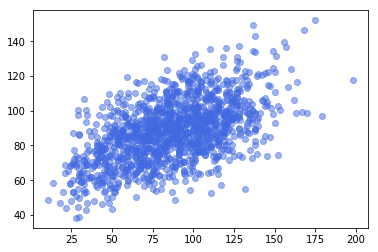

In [46]:
plt.scatter(validation_targets, validation_predictions,alpha=0.5,color="royalblue")

In [48]:
def ploter(y_test_0,pronosticados_0):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')

    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

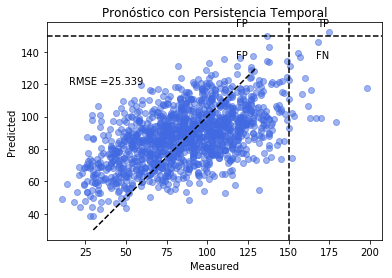

In [49]:
ploter(validation_targets,validation_predictions)

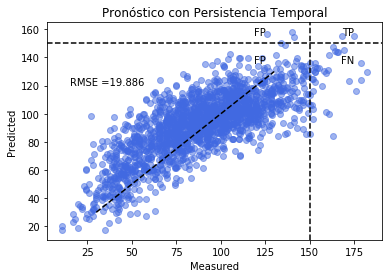

In [163]:
ploter(validation_targets,validation_predictions)